In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from exceptions.Exceptions import ModelNotFoundException
from models import *
from models.custom_data_parallel import CustomDataParallel
from loguru import logger
from torch.autograd import Variable
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn import svm
import json
import pandas as pd
import seaborn as sns


# some global variables
epsilons = ['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3']
models = {
    "RegNetX_200MF": RegNetX_200MF(),
    "VGG": VGG('VGG19'),
    "ResNet18": ResNet18(),
    "GoogLeNet": GoogLeNet(),
    "DenseNet121": DenseNet121(),
    "ResNeXt29_2x64d": ResNeXt29_2x64d(),
    "MobileNet": MobileNet(),
    "PreActResNet18": PreActResNet18(),
    "SENet18": SENet18(),
    "EfficientNetB0": EfficientNetB0()
}


### Load results we generated from all models and plot them

In [2]:
results = None
with open("results.json") as results:
    results = json.load(results)

In [3]:
# Collect all accuracies so far
model_accuracies = {key:[] for key in list(models.keys())}
model_examples = {key:[] for key in list(models.keys())}

for e in epsilons:
    for model, acc in results[e]['accuracies'].items():
        model_accuracies[model].append(acc)
    for model, ex in results[e]['examples'].items():
        model_examples[model].append(ex)

model_accuracies['epsilon'] = epsilons

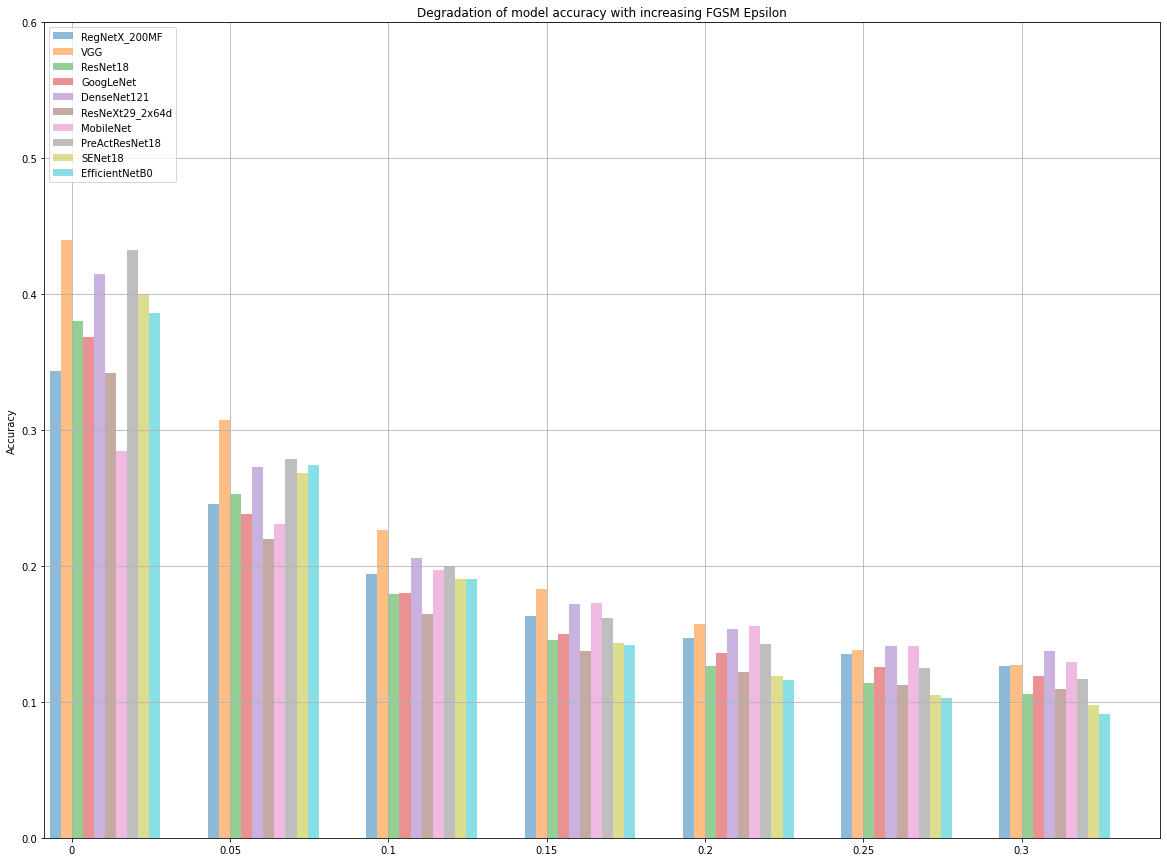

In [4]:
df = pd.DataFrame.from_dict(model_accuracies)
# Setting the positions and width for the bars
pos = list(range(len(df['epsilon']))) 
width = 0.07
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(20,15))
# Create a bar with pre_score data,
# in position pos,
multiplier = 0
for model in models.keys():
    plt.bar([p + multiplier for p in pos], 
            #using df['pre_score'] data,
            df[model], 
            # of width
            width, 
            # with alpha 0.5
            alpha=0.5, 
            # with label the first value in first_name
            label=model) 
    multiplier += width

# Set the y axis label
ax.set_ylabel('Accuracy')

# Set the chart's title
ax.set_title('Degradation of model accuracy with increasing FGSM Epsilon')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['epsilon'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*len(df['epsilon'])*2)
plt.ylim([0, 0.6] )

# Adding the legend and showing the plot
plt.legend(list(models.keys()), loc='upper left')
plt.grid()
plt.show()

## Let's see some of these examples

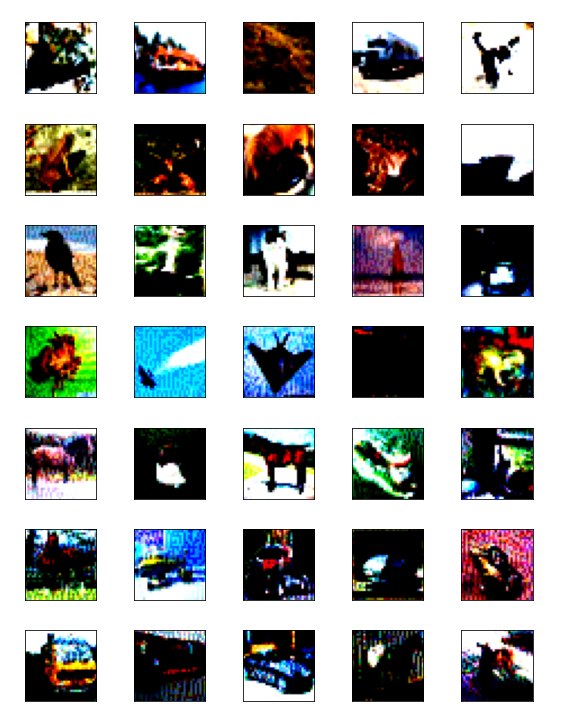

In [7]:
# Plot several examples of adversarial samples at each epsilon
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
cnt = 0
examples = model_examples['RegNetX_200MF']

class_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(class_dict[orig], class_dict[adv]))
        single_img_reshaped = np.transpose(np.reshape(ex,(3, 32,32)), (1,2,0))
        plt.imshow(single_img_reshaped)
plt.tight_layout()
plt.show()

5